In [1]:
import numpy as np
import matplotlib.pyplot as plt
import QM as qm

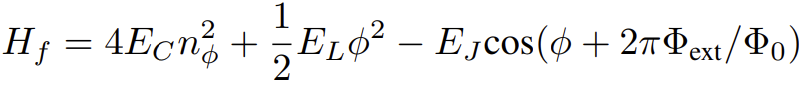

In [2]:
L = 15
N = 256
x = np.linspace(-L,L,N) #this is phi above
dx = 2*L/(N-1)

In [3]:
EC = 0.5 #GHz
EL = 0.25
EJ = 4
Phi_ext = 0.45 #Phi_0

In [17]:
def V(x):
    return 0.5*EL*x**2 - EJ*np.cos(x + 2*np.pi*Phi_ext)

In [18]:
Potential_energy = np.diag(V(x))
Kinetic_energy = -4*EC/dx**2*(np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1),1) + np.diag(np.ones(N-1),-1))

# #For some reason this doesn't yield the same as using the QM library??
# H = Kinetic_energy + Potential_energy #
# eigvals, eigvecs = np.linalg.eig(H)
# tmp = np.argsort(eigvals)
# eigvals = eigvals[tmp]
# eigvecs = eigvecs[:,tmp]

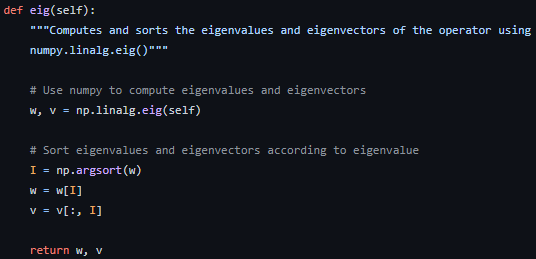

In [19]:
H = qm.operator(Kinetic_energy + Potential_energy)
eigvals, eigvecs = H.eig()

NameError: name 'ymin' is not defined

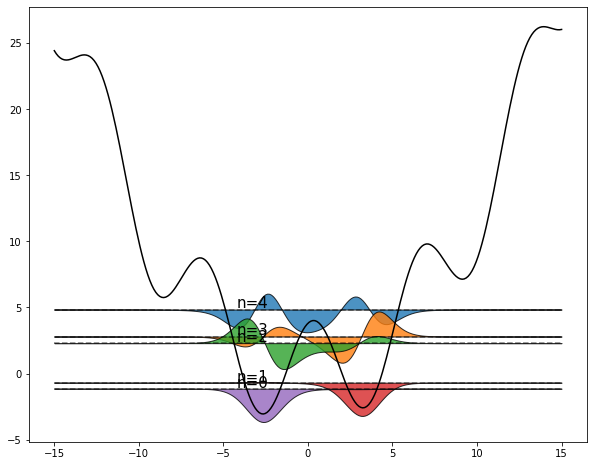

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x,V(x),'k')
xmin,xmax = -L,L
# ymin,ymax = -3.2,10
#ymin,ymax = -1.1,0.6
for i in range(4,-1,-1):
    ax.fill_between(x,eigvecs[i]*10+eigvals[i],[eigvals[i] for _ in x],label='n=%d'%i,edgecolor='k',alpha=0.8)
    ax.text(-4.2,eigvals[i]+0.1,'n=%d'%i,fontsize=15)
    ax.hlines(eigvals[i],xmin,xmax,linestyle='--',alpha=0.5)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
# ax.legend()
ax.set_title("First 5 eigenstates of the Harmonic potential",fontsize=20)
ax.set_yticks(eigvals[:6])
ax.set_xlabel('Position, $\\tilde{x}$',fontsize=15)
ax.set_ylabel('Energy, $\\tilde{E}$',fontsize=15)
plt.show()

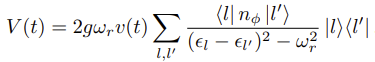

In [8]:
g = 0.3#*2*np.pi #GHz
omega_r = 7.5#*2*np.pi #GHz

In [9]:
diff_x = (np.diag(np.ones(N-1),1) - np.diag(np.ones(N-1),-1))/(2*dx)
p_operator = qm.operator(-1j*diff_x)

In [10]:
V = np.zeros((4,4),dtype=complex)

for l in range(4):
    for l_prime in range(4):
        numerator = qm.bra(eigvecs[l])*p_operator*qm.ket(eigvecs[l_prime])
        denominator = (eigvals[l] - eigvals[l_prime])**2 - omega_r**2
        V[l,l_prime] = numerator/denominator

V = 2*g*omega_r*V

In [106]:
import torch
from time import time
#from tqdm import tqdm

In [107]:
H0 = np.diag(eigvals[:4] - eigvals[0])

H0 = torch.tensor(H0)
V = torch.tensor(V)
identity = torch.diag(torch.ones(4,dtype=torch.complex128))

In [108]:
T = 60
n_steps = 420
times = torch.linspace(0,T,n_steps)
dt = T/n_steps
exp_H0 = torch.matrix_exp(-0.5j*H0*dt)

In [109]:
def evolve(pulse):
    U=identity
    for pulse_step in pulse:
        tmp = torch.matrix_exp(-1j*pulse_step*V*dt)
        U = torch.matmul(U,torch.matmul(exp_H0,torch.matmul(tmp,exp_H0)))
    return U

# exp_H0_2 = torch.matrix_exp(-1j*H0*dt)
# def evolve(pulse):
#     U = torch.matmul(exp_H0,torch.matrix_exp(-1j*pulse[0]*V*dt))
#     for pulse_step in pulse[1:]:
#         tmp = torch.matrix_exp(-1j*pulse_step*V*dt)
#         U = torch.matmul(U,torch.matmul(exp_H0_2,tmp))
#     return torch.matmul(U,exp_H0)

In [110]:
# class MyModule(torch.jit.ScriptModule):
#     def __init__(self):
#         super().__init__()
#         self.pulse = torch.nn.parameter.Parameter(torch.tensor(np.ones(n_steps)))
#         self.exp_H0 = exp_H0
#         self.V = V
#         self.dt = dt
        
    
#     @torch.jit.script_method
#     def forward(self):
#         U = torch.matmul(self.exp_H0,self.matrix_exp(-1j*self.pulse[0]*self.V*self.dt))
#         for pulse_step in self.pulse[1:]:
#             tmp = torch.matrix_exp(-1j*pulse_step*self.V*self.dt)
#             U = torch.matmul(U,torch.matmul(exp_H0_2,tmp))
#         return torch.matmul(U,exp_H0)
    
#     @torch.jit.script_method
#     def matrix_exp(self,inp: complex):
#         return torch.matrix_exp(inp)
    
#     @torch.jit.script_method
#     def matmul(self,M1,M2):
#         return torch.matmul(M1,M2)

In [111]:
# @torch.jit.script
# def evolve_3(pulse, H0 = H0, dt = dt):
#     fodder = -0.5j*H0*dt
#     U = torch.matrix_exp(H0*dt)
#     return pulse

In [123]:
target_gate_adj = torch.tensor([[1,0,0,0],[0,np.exp(-0.25j*np.pi),0,0],[0,0,1,0],[0,0,0,1]],dtype=torch.complex128).adjoint()

def C1(gate):
    return 1 - 1/4**2*torch.abs(torch.trace(torch.matmul(target_gate_adj,gate)))**2

def C4(pulse):
    return (pulse**2).sum()

def loss_func(gate,pulse):
    return C1(gate)# + 0.0001*C4(pulse)

In [124]:
pulse = torch.nn.parameter.Parameter(torch.tensor(np.ones(n_steps)))

loss = loss_func(evolve(pulse),pulse)

optimizer = torch.optim.Adam([pulse],lr=1e-2)
loss.backward()
optimizer.step()

print(f"Initial loss: {loss}")

N = 1

start = time()
#with tqdm(total=1000) as pbar:
while loss >=0.005 and N<=1000:
    optimizer.zero_grad()
    loss = loss_func(evolve(pulse),pulse)
    loss.backward()
    optimizer.step()
    N += 1
    #pbar.update(1)
    print(loss.item(), N, end='\r')
print(N, time() - start)

Initial loss: 0.7699273186728779
1001 390.202713251113901


In [132]:
start = time()
#with tqdm(total=1000) as pbar:
while loss >=0.001 and N<=2000:
    optimizer.zero_grad()
    loss = loss_func(evolve(pulse),pulse)
    loss.backward()
    optimizer.step()
    N += 1
    #pbar.update(1)
    print(loss.item(), N, end='\r')
print(N, time() - start)

1978 57.554788589477541978


In [125]:
energies = np.array([eigvals[3]-eigvals[2],
                     eigvals[2]-eigvals[1],
                     eigvals[3]-eigvals[1],
                     eigvals[2]-eigvals[0],
                     eigvals[3]-eigvals[0]])

In [126]:
tmp = torch.tensor([1,0,0,0],dtype=torch.complex128)

torch.matmul(evolve(pulse),tmp)

tensor([ 0.6779+0.7311j, -0.0027-0.0130j,  0.0081-0.0081j, -0.0401-0.0642j],
       dtype=torch.complex128, grad_fn=<MvBackward0>)

(0, 5)

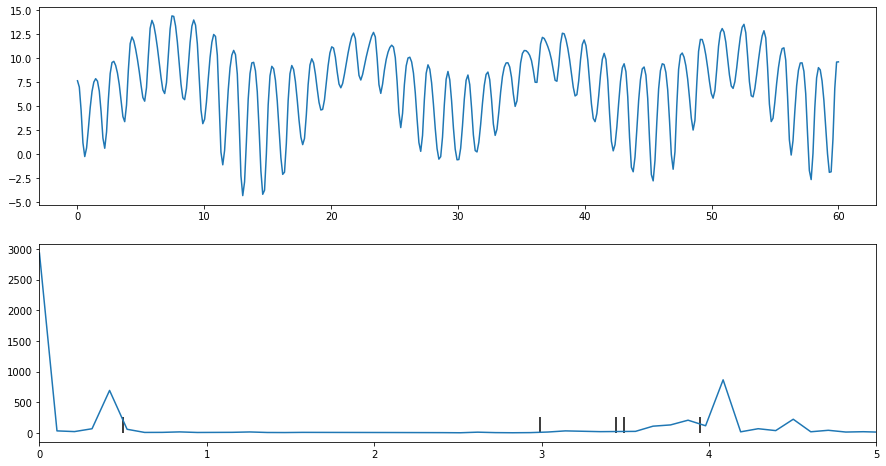

In [133]:
fig, ax = plt.subplots(figsize=(15,8),nrows=2)

ax[0].plot(times.numpy(),pulse.detach().numpy())
ax[1].plot(np.linspace(0,np.pi/dt,n_steps//2+1),np.abs(np.fft.rfft(pulse.detach().numpy())))
ax[1].vlines(energies,0,250)
#ax[1].vlines(eigvals[:4]-eigvals[0],0,250,'r')
ax[1].set_xlim(0,5)